In [3]:
import numpy as np
import warnings
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import os
import imutils
import dlib
import cv2
import imageio
from PIL import Image
from imutils import face_utils
import time
from keras.utils import np_utils, generic_utils
import shutil
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from skimage.transform import resize
from sklearn.utils import shuffle
from skimage.io import imread, imsave, imshow
import tensorflow
import keras
from keras import layers
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential, load_model
from keras.layers import Activation, GlobalAveragePooling2D,GlobalMaxPool2D,ZeroPadding3D, Bidirectional,TimeDistributed, LSTM, GRU, Reshape,BatchNormalization, ConvLSTM2D, ConvLSTM3D,Input
from keras.utils import plot_model
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
# from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3


warnings.filterwarnings("ignore")

In [1]:
!git clone https://github.com/rizkiarm/LipNet/

Cloning into 'LipNet'...


In [1]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

words = ['Begin','Choose','Connection','Navigation','Next', 'Previous', 'Start','Stop','Hello','Web']
phrases = ["Stop navigaton","Excuse me","I am sorry","Thank you",'Good bye','I love this game','Nice to meet you','You are welcome','How are you?','Have a good time']
phrases_di = {i:phrases[i] for i in range(len(phrases))}


words_di = {i:words[i] for i in range(len(words))}
unseen_test = ['F04']
unseen_validation = ['F07','M02']
starting_path = 'C:\\Users\\Jai K\\CS Stuff\\Python\\ISR Project\\dataset\\dataset'
people = ['F01','F02','F04','F05','F06','F07','F08','F09','F10','F11','M01','M02','M04','M07','M08']
#people = ['F01']
data_types = ['words']
folder_nums = ['01','02','03','04','05','06','07','08','09','10']
instances = ['01','02','03','04','05','06','07','08','09','10']
image_nums = ['color_001','color_002','color_003','color_004','color_005','color_006','color_007','color008','color_009','color_010']#,'color_11','color_12','color_13']

In [2]:
print(words_di)

{0: 'Begin', 1: 'Choose', 2: 'Connection', 3: 'Navigation', 4: 'Next', 5: 'Previous', 6: 'Start', 7: 'Stop', 8: 'Hello', 9: 'Web'}


In [3]:
def crop_and_save():
    MAX_HEIGHT = 100
    MAX_WIDTH = 100
    max_seq_length = 10
    t1 = time.time()
    hog_face_detector = dlib.get_frontal_face_detector()
    dlib_facelandmark = dlib.shape_predictor('C:\\Users\\Jai K\\CS Stuff\\Python\\ISR Project\\shape_predictor_68_face_landmarks.dat')

    for person in people:
        tx1 = time.time()
        for data_type in data_types:
            for word_index,folder in enumerate(tqdm(folder_nums)):
                for instance in instances:
                    sequence = []
                    #sequence = np.array(sequence)
                    for image in image_nums:
                        path = starting_path + '\\' + person + '\\' + data_type + '\\' + folder + '\\'+instance + '\\' + image + '.jpg'
                        

                        if(os.path.exists(path) and path.__contains__('color')):
                            frame = cv2.imread(path)
                            
                            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                            x_arr = []
                            y_arr = []
                            gray = imutils.resize(gray, width=500)
                            copy = gray.copy()
                            faces = hog_face_detector(gray)
                            for face in faces:

                                face_landmarks = dlib_facelandmark(gray, face)

                                for n in range(48, 68):
                                    x = face_landmarks.part(n).x
                                    y = face_landmarks.part(n).y
                                    x_arr.append(x)
                                    y_arr.append(y)
                                    #print(face_landmarks.part(n))

                                    xmax = max(x_arr)
                                    xmin = min(x_arr)
                                    ymax = max(y_arr)
                                    ymin = min(y_arr)

                                    cv2.circle(gray, (x, y), 1, (0, 255, 255), 1)
                            copy = copy[ymin-1:ymax+3, xmin-5:xmax+5]
                            width2 = 100
                            height2 = 100
                            dim = (width2, height2)
                            resized_cropped = cv2.resize(copy, dim, interpolation = cv2.INTER_AREA)
                            MAX_WIDTH, MAX_HEIGHT = resized_cropped.shape
                            max_seq_length = 10
                            resized_cropped = resized_cropped.astype(np.uint8)
                            sequence.append(resized_cropped)
                        else:
                            continue
                    pad_array = [np.zeros((MAX_WIDTH, MAX_HEIGHT))]           
                    sequence.extend(pad_array * (max_seq_length - len(sequence)))
                    sequence = np.array(sequence)
                    if person in unseen_test:
                        x_test.append(sequence)
                        y_test.append(word_index)
                    elif person in unseen_validation:
                        x_val.append(sequence)
                        y_val.append(word_index)
                    else:
                        x_train.append(sequence)
                        y_train.append(word_index)
        tx2 = time.time()
        print(f'Finished reading images for person {person}. Time taken : {tx2 - tx1} secs.')
    t2 = time.time()
    print(f"Time taken to create 3D Tensor from cropped lip images: {t2 - t1} secs")

In [4]:
crop_and_save()

100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


Finished reading images for person F01. Time taken : 14.838965654373169 secs.


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


Finished reading images for person F02. Time taken : 15.49447751045227 secs.


100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


Finished reading images for person F04. Time taken : 21.688720703125 secs.


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Finished reading images for person F05. Time taken : 17.238247871398926 secs.


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


Finished reading images for person F06. Time taken : 24.368489503860474 secs.


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


Finished reading images for person F07. Time taken : 26.756532192230225 secs.


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


Finished reading images for person F08. Time taken : 16.17273712158203 secs.


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


Finished reading images for person F09. Time taken : 17.35946822166443 secs.


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


Finished reading images for person F10. Time taken : 15.599406719207764 secs.


100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


Finished reading images for person F11. Time taken : 15.285808324813843 secs.


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


Finished reading images for person M01. Time taken : 16.26610517501831 secs.


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


Finished reading images for person M02. Time taken : 17.318353176116943 secs.


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


Finished reading images for person M04. Time taken : 17.377177238464355 secs.


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


Finished reading images for person M07. Time taken : 16.043601512908936 secs.


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]

Finished reading images for person M08. Time taken : 14.633288621902466 secs.
Time taken to create 3D Tensor from cropped lip images: 267.35346245765686 secs


In [5]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

# x_val = x_train[:10,:]
# x_test= x_train[10:20,:]
# x_train = x_train[20:,:]
# y_val = y_train[:10]
# y_test= y_train[10:20]
# y_train = y_train[20:]


print("X Training shape: ",x_train.shape)
print("X Test shape: ",x_test.shape)
print("X Validation shape: ",x_val.shape)
print("Y Training shape: ",y_train.shape)
print("Y Test shape: ",y_test.shape)
print("Y Validation shape: ",y_val.shape)

X Training shape:  (1200, 10, 100, 100)
X Test shape:  (100, 10, 100, 100)
X Validation shape:  (200, 10, 100, 100)
Y Training shape:  (1200,)
Y Test shape:  (100,)
Y Validation shape:  (200,)


In [14]:
x =np.isnan(x_val).sum()
print(x)

0


In [33]:
def normalize_it(X):
    # print(np.isnan(X).sum())
    # mean = np.mean(X,axis=(2,3),keepdims=True)

    # std = np.std(X,axis=(2,3),  keepdims=True)
    # print((std==0).sum())
    # X = (X - mean)/std
    # print(np.isnan(X).sum())
    v_min = X.min(axis=(2, 3), keepdims=True)
    v_max = X.max(axis=(2, 3), keepdims=True)
    #print(v_min)
    #print('Max: ',v_max)
    X = (X - v_min)/(v_max - v_min)
    X = np.nan_to_num(X)
    return X
    

In [35]:
def clean(x_train,x_val,x_test,y_train,y_val,y_test):
    print()
    print("Normalizing data...")
    t1 = time.time()
    x_train = normalize_it(x_train)
    #print(X_train)
    x_val = normalize_it(x_val)
    x_test = normalize_it(x_test)
    t2 =time.time()
    print()
    print(f"Time taken to normalize images: {t2 - t1} secs")

    print()
    print("One hot encoding labels...")
    t3 = time.time()
    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)
    y_val = np_utils.to_categorical(y_val, 10)
    t4 = time.time()
    print()
    print(f"Time taken to convert labels to categorical: {t4 - t3} secs")

    print()
    print("Shuffling data...")
    t5 = time.time()
    X_train, y_train = shuffle(x_train, y_train, random_state=0)
    X_test, y_test = shuffle(x_test, y_test, random_state=0)
    X_val, y_val = shuffle(x_val, y_val, random_state=0)
    t6 = time.time()
    print()
    print(f"Time taken to shuffle data: {t6 - t5} secs")
    
    print()
    print("Reshaping data...")
    t7 = time.time()
    x_train = np.expand_dims(x_train, axis=4)
    x_val = np.expand_dims(x_val, axis=4)
    x_test = np.expand_dims(x_test, axis=4)
    t8 = time.time()
    print()
    print(f"Time taken to reshape data: {t8 - t7} secs")
    print()

    print(x_train.shape)
    print(x_val.shape)
    print(x_test.shape)
    return x_train, x_val, x_test, y_train, y_val, y_test

In [36]:
x_train, x_val, x_test, y_train, y_val, y_test = clean(x_train,x_val,x_test,y_train,y_val,y_test)

np.save('x_train',x_train)
np.save('x_val',x_val)
np.save('x_test',x_test)
np.save('y_train',y_train)
np.save('y_val',y_val)
np.save('y_test',y_test)


Normalizing data...

Time taken to normalize images: 2.2171103954315186 secs

One hot encoding labels...

Time taken to convert labels to categorical: 0.005981922149658203 secs

Shuffling data...

Time taken to shuffle data: 0.3474314212799072 secs

Reshaping data...

Time taken to reshape data: 0.0 secs

(1200, 10, 100, 100, 1)
(200, 10, 100, 100, 1)
(100, 10, 100, 100, 1)


In [37]:
print(np.argmax(y_test, axis=1))


[2 8 0 5 7 9 1 7 5 9 5 9 7 1 0 3 2 2 3 0 4 6 0 7 4 4 0 9 8 7 6 8 9 6 5 2 1
 5 6 7 0 6 4 4 0 1 1 4 3 0 9 5 0 3 2 5 1 3 2 5 1 3 6 5 7 8 3 8 1 8 1 2 4 9
 9 6 2 9 7 7 2 3 8 4 3 6 5 1 8 7 8 3 2 8 0 9 6 6 4 4]


In [38]:
print(y_train.shape)

y_train30 = y_train[:30,:]
x_train30 = x_train[:30,:]
x_test30 = x_test[:30,:]
y_test30 = y_test[:30,:]
x_val30 = x_val[:30,:]
y_val30 = y_val[:30,:]
print(y_train30.shape)

(1200, 10)
(30, 10)


In [14]:
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
x_val = np.load('x_val.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
y_val = np.load('y_val.npy')

print("X Training shape: ",x_train.shape)
print("X Test shape: ",x_test.shape)
print("X Validation shape: ",x_val.shape)
print("Y Training shape: ",y_train.shape)
print("Y Test shape: ",y_test.shape)
print("Y Validation shape: ",y_val.shape)

X Training shape:  (1200, 10, 100, 100, 1)
X Test shape:  (100, 10, 100, 100, 1)
X Validation shape:  (200, 10, 100, 100, 1)
Y Training shape:  (1200, 10)
Y Test shape:  (100, 10)
Y Validation shape:  (200, 10)


In [39]:
model = Sequential()

# # 1st layer group
model.add(Conv3D(64, (3, 3, 3), strides = 1, input_shape=(13, 100, 100, 1), activation='relu', padding='valid'))

model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(128, (3, 3, 3), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(256, (2, 2, 2), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

#model.add(Conv3D(512,(3,3,3),activation='relu',strides=1))
#model.add(MaxPooling3D(pool_size=(2,2,2),strides=2))
model.add((Flatten()))

# # # FC layers group
model.add(Dense(4096, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

ValueError: Exception encountered when calling layer "conv3d_2" (type Conv3D).

Negative dimension size caused by subtracting 2 from 1 for '{{node conv3d_2/Conv3D}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](Placeholder, conv3d_2/Conv3D/ReadVariableOp)' with input shapes: [?,1,23,23,128], [2,2,2,128,256].

Call arguments received by layer "conv3d_2" (type Conv3D):
  • inputs=tf.Tensor(shape=(None, 1, 23, 23, 128), dtype=float32)

In [34]:
earlyStopping = EarlyStopping(monitor = 'accuracy', patience = 10)
model = Sequential()
#change activation functions - sigmoid, etc
#change strides
# 1st layer group
model.add(Conv3D(32, (3, 3, 3), strides = 1, input_shape=(10, 100, 100, 1), activation='relu', padding='valid'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(64, (3, 3, 3), activation='relu', strides=1,padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))
#model.add(Dropout(0.5))

model.add(Conv3D(128, (3, 3, 3), activation='relu', strides=1,padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

#model.add(Conv3D(256,(3,3,3),activation='relu',strides=1))
#model.add(MaxPooling3D(pool_size=(2,2,2),strides=2))
#model.add(Dropout(0.5))
#print(model.summary())
#model.add(Conv3D(256, (3, 3, 3), activation='relu', strides=1))
#model.add(MaxPooling3D(pool_size=(2,2,2),strides=2))

#model.add(Conv3D(128, (3, 3, 3), activation='relu', strides=1))

shape = (1,10,10,128)
#model.add(Reshape((1,shape[1]*shape[2]*shape[3])))
model.add((Flatten()))
model.add(Dense(10, activation='softmax'))
model.compile(loss = 'categorical_crossentropy',optimizer = 'Adam',metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 8, 98, 98, 32)     896       
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 4, 49, 49, 32)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 4, 49, 49, 64)     55360     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 2, 24, 24, 64)    0         
 3D)                                                             
                                                                 
 conv3d_6 (Conv3D)           (None, 2, 24, 24, 128)    221312    
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 1, 12, 12, 128)  

In [31]:
model = Sequential()
# 1st layer group

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu',name='conv1',strides=(1, 1, 1),input_shape=(13,100,100,1)))


model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(1,2,2),padding='valid', name='pool1'))
model.add(LSTM(64, return_sequences=True, name='lstm1'))
# 2nd layer group

model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu',padding='same', name='conv2',strides=(1, 1, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),padding='valid', name='pool2'))
model.add(LSTM(128, return_sequences=True, name='lstm2'))
# 3rd layer group

model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu',padding='same', name='conv3a',strides=(1, 1, 1)))
model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu',padding='same', name='conv3b',strides=(1, 1, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),padding='valid', name='pool3'))
model.add(LSTM(256, return_sequences=True, name='lstm3'))
# 4th layer group
model.add(Dense(4096, activation='relu', name='fc6'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu', name='fc7'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

# model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu',padding='same', name='conv4a',strides=(1, 1, 1)))
# model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu',padding='same', name='conv4b',strides=(1, 1, 1)))
# print(model.summary())

# model.add(MaxPooling3D( strides=(2, 2, 2),padding='valid', name='pool4'))

# # 5th layer group

# model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu',padding='same', name='conv5a',strides=(1, 1, 1)))
# model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu',padding='same', name='conv5b',strides=(1, 1, 1)))
# model.add(ZeroPadding3D(padding=(0, 1, 1)))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),padding='valid', name='pool5'))
# model.add(Flatten())
# # FC layers group
# model.add(Dense(4096, activation='relu', name='fc6'))
# model.add(Dropout(0.5))
# model.add(Dense(4096, activation='relu', name='fc7'))
# model.add(Dropout(0.5))
# model.add(Dense(10, activation='softmax'))

print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


ValueError: Input 0 of layer "lstm1" is incompatible with the layer: expected ndim=3, found ndim=5. Full shape received: (None, 10, 49, 49, 64)

In [43]:
earlyStopping = EarlyStopping(monitor='accuracy', patience=10)
model = Sequential()
model.add((Conv3D(25,strides=(1,2,2),kernel_size=(3,3,3),padding='same',input_shape=(10,100,100,1))))

model.add(Reshape((10,10,5,50,25)))
#model.add(Reshape((10,62500)))

model.add(Bidirectional(ConvLSTM3D(128,kernel_size=(3,3,3),return_sequences=True)))
model.add(Bidirectional(ConvLSTM3D(128,kernel_size=(3,3,3),return_sequences=True)))

model.add(Flatten())
model.add(Dense(10,activation='softmax'))
print(model.summary())  
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 10, 50, 50, 25)    700       
                                                                 
 reshape (Reshape)           (None, 10, 10, 5, 50, 25  0         
                             )                                   
                                                                 
 bidirectional (Bidirectiona  (None, 10, 8, 3, 48, 256  4231168  
 l)                          )                                   
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 6, 1, 46, 256  10617856 
 nal)                        )                                   
                                                                 
 flatten_2 (Flatten)         (None, 706560)            0         
                                                      

In [42]:
model = Sequential()
model.add(Conv3D(64,kernel_size=1,activation='relu',input_shape=(10,100,100,1)))
model.add(MaxPooling3D(strides=(2,2,2)))

model.add(Conv3D(128,kernel_size=1,activation='relu'))
model.add(MaxPooling3D(strides=(2,2,2)))

model.add(Conv3D(256,kernel_size=1,activation='relu'))
model.add(MaxPooling3D(strides=(2,2,2)))

model.add(Conv3D(512,kernel_size=1,activation='relu'))
#model.add(MaxPooling3D(strides=(2,2,2)))

#model.add(Conv3D(1024,kernel_size=1,activation='relu'))


model.add(Flatten())

model.add(Dense(10,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 10, 100, 100, 64)  128       
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 5, 50, 50, 64)    0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 5, 50, 50, 128)    8320      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 2, 25, 25, 128)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 2, 25, 25, 256)    33024     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 1, 12, 12, 256)  

In [18]:
# import lipnet
# from lipnet.core.layers import CTC
input_shape = (10,100,100,1)
model = Sequential()
model.add(Input(name='input',shape=input_shape,dtype='float32'))
model.add(ZeroPadding3D(padding=(1, 2, 2), name='zero1'))

print(model.summary())

model.add((Conv3D(32, (3, 5, 5), strides=(1, 2, 2), activation='relu', kernel_initializer='he_normal', name='conv1')))
model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max1'))
model.add(Dropout(0.5))

model.add(ZeroPadding3D(padding=(1, 2, 2), name='zero2'))
model.add(Conv3D(64, (3, 5, 5), strides=(1, 1, 1), activation='relu', kernel_initializer='he_normal', name='conv2'))
model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max2'))
model.add(Dropout(0.5))

model.add(ZeroPadding3D(padding=(1, 1, 1), name='zero3'))
model.add(Conv3D(96, (3, 3, 3), strides=(1, 1, 1), activation='relu', kernel_initializer='he_normal', name='conv3'))
model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max3'))
model.add(Dropout(0.5))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(GRU(256, return_sequences=True, kernel_initializer='Orthogonal', name='gru1'), merge_mode='concat'))
model.add(Bidirectional(GRU(256, return_sequences=True, kernel_initializer='Orthogonal', name='gru2'), merge_mode='concat'))
model.add(Flatten())
model.add(Dense(10,activation='softmax'))
print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero1 (ZeroPadding3D)       (None, 12, 104, 104, 1)   0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero1 (ZeroPadding3D)       (None, 12, 104, 104, 1)   0         
                                                                 
 conv1 (Conv3D)              (None, 10, 50, 50, 32)    2432      
                                                                 
 max1 (MaxPooling3D)         (None, 10, 25, 25, 32)    0         
                                                                 
 dropout_6 (Dropout)         (Non

NameError: name 'x_train30' is not defined

In [77]:
np.isnan(y_train).sum()

0

In [19]:
t1 = time.time()
#history = model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks = [earlyStopping], epochs=45)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=45)
t2 = time.time()
print()
print(f"Training time : {(t2 - t1)/60} mins.")

Epoch 1/45
38/38 [==============================] - 160s 4s/step - loss: 2.7987 - accuracy: 0.1192 - val_loss: 2.5321 - val_accuracy: 0.1000
Epoch 2/45
38/38 [==============================] - 165s 4s/step - loss: 2.3884 - accuracy: 0.0933 - val_loss: 2.3248 - val_accuracy: 0.1000
Epoch 3/45
38/38 [==============================] - 184s 5s/step - loss: 2.3591 - accuracy: 0.0950 - val_loss: 2.3238 - val_accuracy: 0.0950
Epoch 4/45
38/38 [==============================] - 184s 5s/step - loss: 2.3284 - accuracy: 0.1000 - val_loss: 2.3223 - val_accuracy: 0.1000
Epoch 5/45
12/38 [========>.....................] - ETA: 1:53 - loss: 2.3143 - accuracy: 0.0964

KeyboardInterrupt: 

In [36]:
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


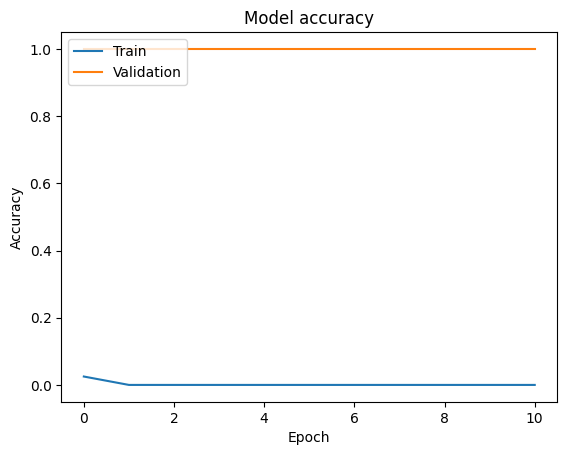

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

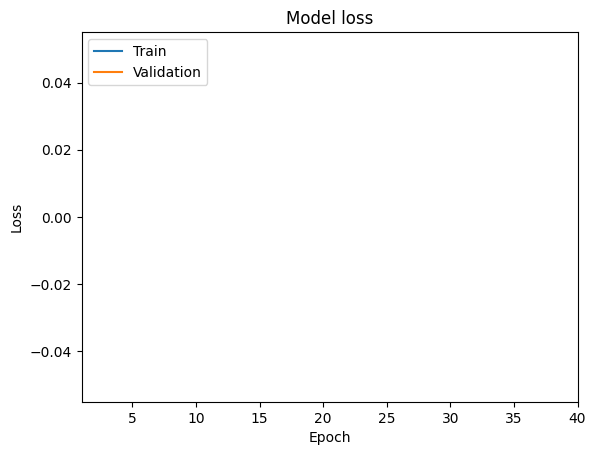

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(1, 40)
# plt.ylim(0, 3)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [39]:
ypred = model.predict(x_test)

# predicted_words = [words[i] for i in np.argmax(ypred, axis=1)]
# actual_words = [words[i] for i in np.argmax(y_test,axis=1)]
predicted_words = [phrases[i] for i in np.argmax(ypred, axis=1)]
actual_words = [phrases[i] for i in np.argmax(y_test,axis=1)]

1/1 [==============================] - 1s 892ms/step


In [40]:
correct = 0
for p, a in zip(predicted_words, actual_words):
    if p == a:
        correct += 1
    print(f"Predicted : {p} \t Actual : {a}")

accuracy = correct/len(actual_words)
print()
print()
print(f"Accuracy = {accuracy*100}% on training data")

Predicted : Stop navigaton 	 Actual : Excuse me
Predicted : Stop navigaton 	 Actual : Excuse me
Predicted : Stop navigaton 	 Actual : Excuse me
Predicted : Stop navigaton 	 Actual : Excuse me
Predicted : Stop navigaton 	 Actual : Excuse me
Predicted : Stop navigaton 	 Actual : Excuse me
Predicted : Stop navigaton 	 Actual : Excuse me
Predicted : Stop navigaton 	 Actual : Excuse me
Predicted : Stop navigaton 	 Actual : Excuse me
Predicted : Stop navigaton 	 Actual : Excuse me


Accuracy = 0.0% on training data
